In [1]:
# Simplified Implementation with Stable Baselines 3

# First, install Stable Baselines 3
!pip install stable-baselines3[extra] gymnasium matplotlib

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import os

from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 112.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 17.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [2]:
# Create directories
os.makedirs("models", exist_ok=True)
os.makedirs("logs", exist_ok=True)
os.makedirs("plots", exist_ok=True)


In [3]:
class PCAWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_components=2):
        super().__init__(env)
        self.n_components = n_components
        self.pca = None
        self.scaler = StandardScaler()

        # Store original observation space
        self.orig_obs_space = env.observation_space

        # Update observation space
        low = np.full(n_components, -np.inf, dtype=np.float32)
        high = np.full(n_components, np.inf, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

        # Initialize PCA with random samples
        self._init_pca()

    def _init_pca(self, n_samples=1000):
        print("Collecting samples for PCA...")
        samples = []
        obs, _ = self.env.reset()

        for _ in range(n_samples):
            action = self.env.action_space.sample()
            obs, _, terminated, truncated, _ = self.env.step(action)
            samples.append(obs)

            if terminated or truncated:
                obs, _ = self.env.reset()

        samples = np.array(samples)

        self.scaler.fit(samples)
        scaled_samples = self.scaler.transform(samples)

        self.pca = PCA(n_components=self.n_components)
        self.pca.fit(scaled_samples)

        explained_variance = self.pca.explained_variance_ratio_
        print(f"Variance explained by {self.n_components} components: {np.sum(explained_variance):.4f}")
        print(f"Individual components: {explained_variance}")

    def observation(self, observation):
        scaled_obs = self.scaler.transform(observation.reshape(1, -1))
        reduced_obs = self.pca.transform(scaled_obs).flatten()
        return reduced_obs.astype(np.float32)


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gymnasium as gym
from torch.utils.data import TensorDataset, DataLoader


class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_dim=64):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)
        )

        # Encoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    def encode(self, x):
        return self.encoder(x)

In [5]:
class AutoencoderWrapper(gym.ObservationWrapper):
    def __init__(self, env, encoding_dim=2, hidden_dim=64, learning_rate=1e-3,
                 batch_size=64, n_epochs=10, device='cuda' if torch.cuda.is_available() else 'cpu'):
        super().__init__(env)
        self.encoding_dim = encoding_dim
        self.hidden_dim = hidden_dim
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.device = device

        self.input_dim = np.prod(env.observation_space.shape)

        self.autoencoder = Autoencoder(self.input_dim, encoding_dim, hidden_dim).to(device)
        self.optimizer = optim.Adam(self.autoencoder.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()

        self.orig_obs_space = env.observation_space

        low = np.full(encoding_dim, -np.inf, dtype=np.float32)
        high = np.full(encoding_dim, np.inf, dtype=np.float32)
        self.observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)

        self._train_autoencoder()

    def _train_autoencoder(self, n_samples=10000):
        print("Collecting samples for autoencoder training...")
        samples = []
        obs, _ = self.env.reset()

        for _ in range(n_samples):
            action = self.env.action_space.sample()
            obs, _, terminated, truncated, _ = self.env.step(action)
            samples.append(obs)

            if terminated or truncated:
                obs, _ = self.env.reset()

        samples = np.array(samples).reshape(len(samples), -1).astype(np.float32)
        samples_tensor = torch.tensor(samples).to(self.device)

        dataset = TensorDataset(samples_tensor, samples_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        print(f"Training autoencoder for {self.n_epochs} epochs...")
        # Train autoencoder
        self.autoencoder.train()
        for epoch in range(self.n_epochs):
            total_loss = 0
            for batch_input, batch_target in dataloader:
                output = self.autoencoder(batch_input)
                loss = self.criterion(output, batch_target)

                # Backward and optimize
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            avg_loss = total_loss / len(dataloader)
            print(f'Epoch [{epoch+1}/{self.n_epochs}], Loss: {avg_loss:.6f}')

        self.autoencoder.eval()
        with torch.no_grad():
            reconstructed = self.autoencoder(samples_tensor)
            mse = self.criterion(reconstructed, samples_tensor).item()
            print(f"Final reconstruction MSE: {mse:.6f}")

    def observation(self, observation):
        obs_tensor = torch.tensor(observation.reshape(1, -1), dtype=torch.float32).to(self.device)
        with torch.no_grad():
            encoded_obs = self.autoencoder.encode(obs_tensor)

        return encoded_obs.cpu().numpy().flatten().astype(np.float32)

Environment: CartPole-v1
Observation space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action space: Discrete(2)
Training on CartPole-v1 with 50000 timesteps

=== BASELINE TRAINING ===
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/PPO_1


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.9     |
|    ep_rew_mean     | 22.9     |
| time/              |          |
|    fps             | 390      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.9        |
|    ep_rew_mean          | 29.9        |
| time/                   |             |
|    fps                  | 403         |
|    iterations           | 2           |
|    time_elapsed         | 10          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008060999 |
|    clip_fraction        | 0.0912      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.686      |
|    explained_variance   | -0.0027     |
|    learning_rate        | 0.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Baseline - Mean reward: 500.00 +/- 0.00

=== PCA TRAINING ===
Variance explained by 2 components: 0.8959
Individual components: [0.74177164 0.15411793]
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/PPO_2


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.4     |
|    ep_rew_mean     | 22.4     |
| time/              |          |
|    fps             | 509      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.7        |
|    ep_rew_mean          | 27.7        |
| time/                   |             |
|    fps                  | 453         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011611843 |
|    clip_fraction        | 0.155       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.0102      |
|    learning_rate        | 0.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


PCA - Mean reward: 73.20 +/- 18.11

=== AUTOENCODER TRAINING ===
Training autoencoder for 10 epochs...
Epoch [1/10], Loss: 0.061268
Epoch [2/10], Loss: 0.010068
Epoch [3/10], Loss: 0.008745
Epoch [4/10], Loss: 0.005794
Epoch [5/10], Loss: 0.002123
Epoch [6/10], Loss: 0.001432
Epoch [7/10], Loss: 0.001354
Epoch [8/10], Loss: 0.001316
Epoch [9/10], Loss: 0.001286
Epoch [10/10], Loss: 0.001249
Final reconstruction MSE: 0.001253
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/PPO_3


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 23.9     |
|    ep_rew_mean     | 23.9     |
| time/              |          |
|    fps             | 629      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29.5        |
|    ep_rew_mean          | 29.5        |
| time/                   |             |
|    fps                  | 518         |
|    iterations           | 2           |
|    time_elapsed         | 7           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007662113 |
|    clip_fraction        | 0.0796      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.00128    |
|    learning_rate        | 0.

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Autoencoder - Mean reward: 408.80 +/- 120.71


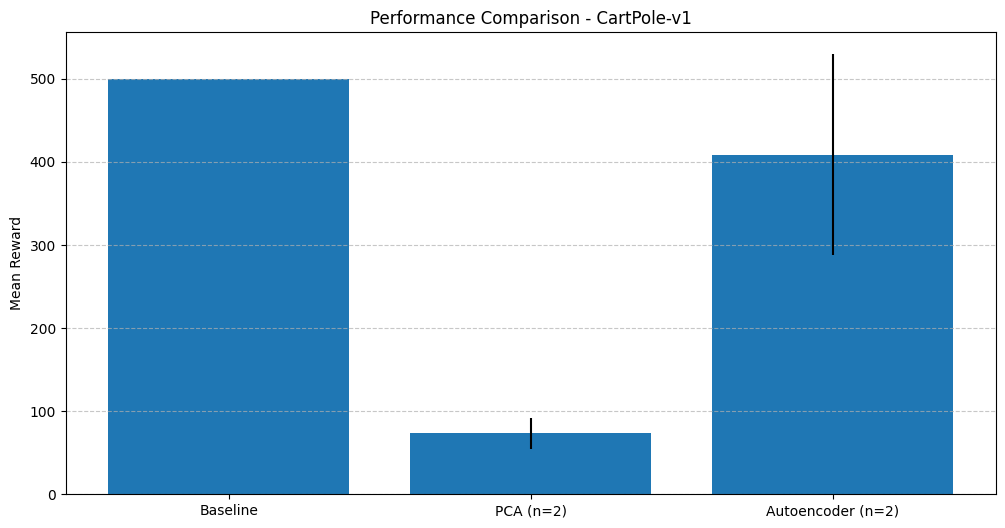


=== FINAL RESULTS ===
Baseline mean reward: 500.00
PCA mean reward: 73.20
Autoencoder mean reward: 408.80

=== PERFORMANCE COMPARISON ===
Baseline outperformed PCA by 426.80 reward
Baseline outperformed autoencoder by 91.20 reward
Autoencoder outperformed PCA by 335.60 reward


In [6]:
# Updated compare_methods function that includes autoencoder
def compare_methods(env_name="CartPole-v1", pca_components=2, ae_components=2, total_timesteps=50000):
    print(f"Training on {env_name} with {total_timesteps} timesteps")

    # Baseline (no dimensionality reduction)
    print("\n=== BASELINE TRAINING ===")
    env = gym.make(env_name)
    model_baseline = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./logs/")
    model_baseline.learn(total_timesteps=total_timesteps)
    model_baseline.save("models/baseline")

    # Evaluate baseline
    mean_reward_baseline, std_reward_baseline = evaluate_policy(model_baseline, env, n_eval_episodes=10)
    print(f"Baseline - Mean reward: {mean_reward_baseline:.2f} +/- {std_reward_baseline:.2f}")

    # PCA
    print("\n=== PCA TRAINING ===")
    env_pca = PCAWrapper(gym.make(env_name), n_components=pca_components)
    model_pca = PPO("MlpPolicy", env_pca, verbose=1, tensorboard_log="./logs/")
    model_pca.learn(total_timesteps=total_timesteps)
    model_pca.save("models/pca")

    # Evaluate PCA
    mean_reward_pca, std_reward_pca = evaluate_policy(model_pca, env_pca, n_eval_episodes=10)
    print(f"PCA - Mean reward: {mean_reward_pca:.2f} +/- {std_reward_pca:.2f}")

    # Autoencoder
    print("\n=== AUTOENCODER TRAINING ===")
    env_ae = AutoencoderWrapper(gym.make(env_name), encoding_dim=ae_components)
    model_ae = PPO("MlpPolicy", env_ae, verbose=1, tensorboard_log="./logs/")
    model_ae.learn(total_timesteps=total_timesteps)
    model_ae.save("models/autoencoder")

    # Evaluate Autoencoder
    mean_reward_ae, std_reward_ae = evaluate_policy(model_ae, env_ae, n_eval_episodes=10)
    print(f"Autoencoder - Mean reward: {mean_reward_ae:.2f} +/- {std_reward_ae:.2f}")

    # Visualize results
    results = {
        'Method': ['Baseline', f'PCA (n={pca_components})', f'Autoencoder (n={ae_components})'],
        'Mean Reward': [mean_reward_baseline, mean_reward_pca, mean_reward_ae],
        'Std Reward': [std_reward_baseline, std_reward_pca, std_reward_ae]
    }

    plt.figure(figsize=(12, 6))
    plt.bar(results['Method'], results['Mean Reward'], yerr=results['Std Reward'])
    plt.ylabel('Mean Reward')
    plt.title(f'Performance Comparison - {env_name}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig('plots/comparison.png')
    plt.show()

    return {
        'baseline': mean_reward_baseline,
        'pca': mean_reward_pca,
        'autoencoder': mean_reward_ae
    }

# Example usage
if __name__ == "__main__":
    # Configure parameters
    ENV_NAME = "CartPole-v1"  # Simple environment without rendering issues
    PCA_COMPONENTS = 2        # CartPole has 4D state space, reduce to 2D
    AE_COMPONENTS = 2         # Same dimensionality for autoencoder
    TIMESTEPS = 50000         # Training steps

    # Show environment details
    env = gym.make(ENV_NAME)
    print(f"Environment: {ENV_NAME}")
    print(f"Observation space: {env.observation_space}")
    print(f"Action space: {env.action_space}")
    env.close()

    # Run comparison
    results = compare_methods(ENV_NAME, PCA_COMPONENTS, AE_COMPONENTS, TIMESTEPS)

    print("\n=== FINAL RESULTS ===")
    print(f"Baseline mean reward: {results['baseline']:.2f}")
    print(f"PCA mean reward: {results['pca']:.2f}")
    print(f"Autoencoder mean reward: {results['autoencoder']:.2f}")

    # Print differences
    pca_diff = results['pca'] - results['baseline']
    ae_diff = results['autoencoder'] - results['baseline']
    ae_vs_pca = results['autoencoder'] - results['pca']

    print("\n=== PERFORMANCE COMPARISON ===")
    if pca_diff > 0:
        print(f"PCA outperformed baseline by {pca_diff:.2f} reward")
    else:
        print(f"Baseline outperformed PCA by {abs(pca_diff):.2f} reward")

    if ae_diff > 0:
        print(f"Autoencoder outperformed baseline by {ae_diff:.2f} reward")
    else:
        print(f"Baseline outperformed autoencoder by {abs(ae_diff):.2f} reward")

    if ae_vs_pca > 0:
        print(f"Autoencoder outperformed PCA by {ae_vs_pca:.2f} reward")
    else:
        print(f"PCA outperformed autoencoder by {abs(ae_vs_pca):.2f} reward")